
# 🌍 Analyzing Sea Level Rise Using Earth Data in the Cloud
### This notebook is entirely based on Jinbo Wang's [tutorial](https://github.com/betolink/the-coding-club/blob/main/notebooks/Earthdata_webinar_20220727.ipynb)

<img src="https://www.nasa.gov/sites/default/files/styles/full_width/public/thumbnails/image/sealevel_main-causes3-16.jpg?itok=XAqGqps1" width="800px" />

**We are going to plot the orange line**


In [33]:
from earthaccess import Auth, Store, DataGranules, DataCollections
from pprint import pprint

auth = Auth().login(strategy="netrc")
# are we authenticated?
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

# The Store class will let us download data from NASA directly
store = Store(auth)

You're now authenticated with NASA Earthdata Login
Using token with expiration date: 12/23/2022


# Authentication in the cloud

### If the collection is a cloud-hosted collection we can print the `summary()` and get the S3 credential endpoint. These S3 credentials are temporary and we can use them with third party libraries such as s3fs, boto3 or awscli.

In [3]:
# We'll get 4 collections that match with our keywords
collections = DataCollections().keyword("SEA SURFACE HEIGHT").cloud_hosted(True).get(4)

# Let's print 2 collections
for collection in collections[0:2]:
    # pprint(collection.summary())
    print(pprint(collection.summary()) , collection.abstract(), "\n")

{'cloud-info': {'Region': 'us-west-2',
                'S3BucketAndObjectPrefixNames': ['podaac-ops-cumulus-protected/ALTIKA_SARAL_L2_OST_XOGDR/',
                                                 'podaac-ops-cumulus-public/ALTIKA_SARAL_L2_OST_XOGDR/'],
                'S3CredentialsAPIDocumentationURL': 'https://archive.podaac.earthdata.nasa.gov/s3credentialsREADME',
                'S3CredentialsAPIEndpoint': 'https://archive.podaac.earthdata.nasa.gov/s3credentials'},
 'concept-id': 'C2251465126-POCLOUD',
 'file-type': "[{'Format': 'netCDF-4', 'FormatType': 'Native'}]",
 'get-data': ['https://search.earthdata.nasa.gov/search/granules?p=C2251465126-POCLOUD',
              'https://cmr.earthdata.nasa.gov/virtual-directory/collections/C2251465126-POCLOUD'],
 'short-name': 'ALTIKA_SARAL_L2_OST_XOGDR',
 'version': 'f'}
None These data are near-real-time (NRT) (within 7-9 hours of measurement) sea surface height anomalies (SSHA) from the AltiKa altimeter onboard the Satellite with ARgos and

## A year of data 

Things to keep in mind:

* this particular dataset has data until 2019
* this is a global dataset, each granule represents the whole world
* temporal coverage is 1 granule each 5 days

In [4]:
granules = DataGranules().concept_id("C2036880672-POCLOUD").temporal("2017-01","2018-01").get()
print(len(granules))

72


## Working with the URLs directly

If we chose, we can use `earthdata` to grab the file's URLs and then download them with another library (if we have a `.netrc` file configured with NASA's EDL credentials)
Getting the links to our data is quiet simple with the `data_links()` method on each of the results:

In [5]:
# on_prem is a bit misleading, the collection is cloud hosted, in this case the access can be done out of region 
granules[0].data_links(access="onprem")

['https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL1812/ssh_grids_v1812_2017010412.nc']

In [6]:
granules[0].data_links(access="direct")

['s3://podaac-ops-cumulus-protected/SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL1812/ssh_grids_v1812_2017010412.nc']

## POC: streaming into xarray

We can use `earthdata` to stream files directly into xarray, this will work well for cases where:

* Data is in NetCDF/HDF5 format
  * xarray can read bytes directly for remote datasets only with **`h5netcdf`** and **`scipy`** back-ends, if we deal with a format that won't be recognized by these 2 backends xarray will raise an exception.
* Data is not big data (multi TB)
  * not fully tested with Dask distributed
* Data is gridded
  * xarray works better with homogeneous coordinates, working with swath data will be cumbersome.
* Data is chunked using reasonable large sizes(1MB or more)
  * If our files are chunked in small pieces the access time will be orders of magnitude bigger than just downloading the data and accessing it locally.
  
Opening a year of SSH (SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL1812) data (1.1 GB approx) takes about 5 minutes using streaming when we access out of region(not in AWS)

In [7]:
%%time
import xarray as xr

granules = []

# we just grab 1 granule from May for each year of the dataset
for year in range(1990, 2019):
    granule = DataGranules().concept_id("C2036880672-POCLOUD").temporal(f"{year}-05", f"{year}-06").get(1)
    if len(granule)>0:
        granules.append(granule[0])

ds = xr.open_mfdataset(store.open(granules), chunks={})
ds

 Opening 26 granules, approx size: 0.4 GB


SUBMITTING | :   0%|          | 0/26 [00:00<?, ?it/s]

PROCESSING | :   0%|          | 0/26 [00:00<?, ?it/s]

COLLECTING | :   0%|          | 0/26 [00:00<?, ?it/s]

CPU times: user 14.4 s, sys: 7.46 s, total: 21.8 s
Wall time: 2min 29s


<xarray.Dataset>
Dimensions:      (Time: 26, Longitude: 2160, nv: 2, Latitude: 960)
Coordinates:
  * Longitude    (Longitude) float32 0.08333 0.25 0.4167 ... 359.6 359.8 359.9
  * Latitude     (Latitude) float32 -79.92 -79.75 -79.58 ... 79.58 79.75 79.92
  * Time         (Time) datetime64[ns] 1993-05-05T12:00:00 ... 2018-05-04T12:...
Dimensions without coordinates: nv
Data variables:
    Lon_bounds   (Time, Longitude, nv) float32 dask.array<chunksize=(1, 2160, 2), meta=np.ndarray>
    Lat_bounds   (Time, Latitude, nv) float32 dask.array<chunksize=(1, 960, 2), meta=np.ndarray>
    Time_bounds  (Time, nv) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    SLA          (Time, Longitude, Latitude) float32 dask.array<chunksize=(1, 2160, 960), meta=np.ndarray>
    SLA_ERR      (Time, Longitude, Latitude) float32 dask.array<chunksize=(1, 2160, 960), meta=np.ndarray>
Attributes: (12/13)
    Conventions:            CF-1.6
    ncei_template_version:  NCEI_NetCDF_Grid_Template_v2.0
    Institution:            Jet Propulsion Laboratory
    geospatial_lat_min:     -79.916664
    geospatial_lat_max:     79.916664
    geospatial_lon_min:     0.083333336
    ...                     ...
    time_coverage_start:    1993-05-05
    time_coverage_end:      1993-05-05
    date_created:           2019-02-11T20:20:41.809201
    version_number:         1812
    summary:                Sea level anomaly grids from altimeter data using...
    title:                  Sea Level Anormaly Estimate based on Altimeter Data

## Plotting 

/home/betolink/.pyenv/versions/mambaforge/envs/earthaccess-gallery/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


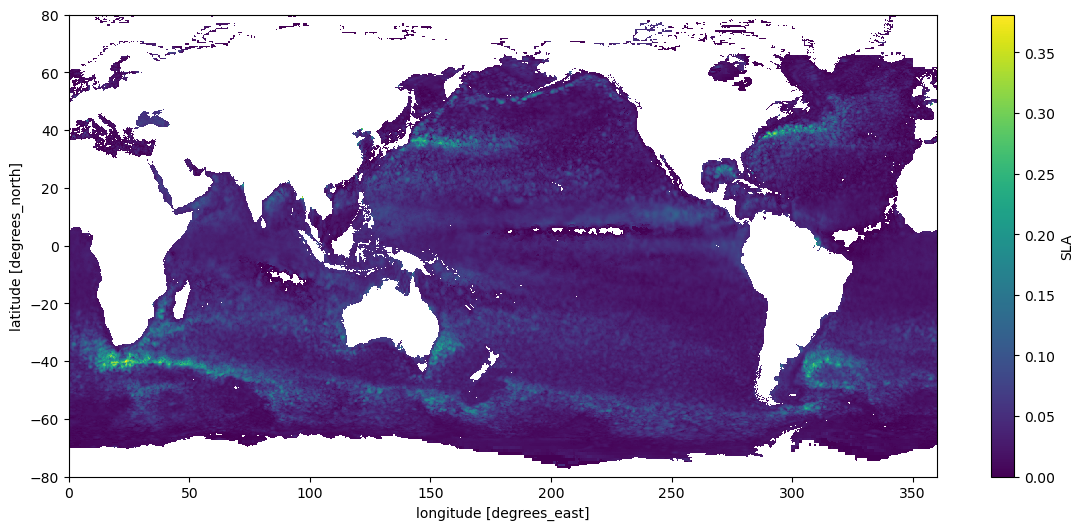

In [28]:
ds.SLA.where((ds.SLA>=0) & (ds.SLA < 10)).std('Time').plot(figsize=(14,6), x='Longitude', y='Latitude')

In [9]:
from pyproj import Geod
import numpy as np

def ssl_area(lats):
    """
    Calculate the area associated with a 1/6 by 1/6 degree box at latitude specified in 'lats'.
    
    Parameter
    ==========
    lats: a list or numpy array of size N the latitudes of interest. 
    
    Return
    =======
    out: Array (N) area values (unit: m^2)
    """
    # Define WGS84 as CRS:
    geod = Geod(ellps='WGS84')
    dx=1/12.0
    # TODO: explain this
    c_area=lambda lat: geod.polygon_area_perimeter(np.r_[-dx,dx,dx,-dx], lat+np.r_[-dx,-dx,dx,dx])[0]
    out=[]
    for lat in lats:
        out.append(c_area(lat))
    return np.array(out)

ssh_area = ssl_area(ds.Latitude.data).reshape(1,-1)
print(ssh_area.shape)

(1, 960)


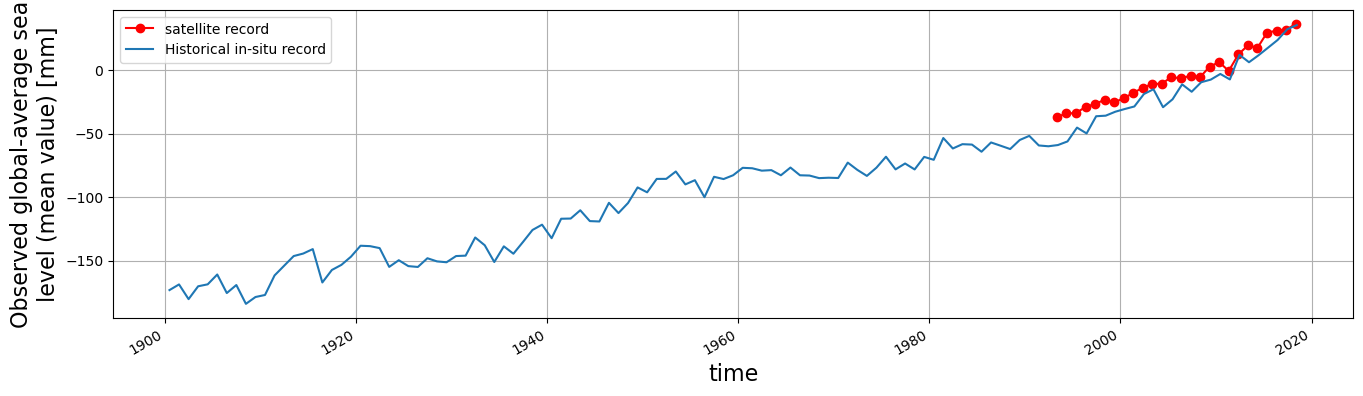

CPU times: user 4.35 s, sys: 198 ms, total: 4.55 s
Wall time: 2.74 s


In [32]:
%%time

import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (16,4)

fig, axs = plt.subplots()
plt.grid(True)

def global_mean(SLA, **kwargs):
    dout=((SLA*ssh_area).sum()/(SLA/SLA*ssh_area).sum())*1000
    return dout

result = ds.SLA.groupby('Time').apply(global_mean)

plt.xlabel('Time (year)',fontsize=16)
plt.ylabel('Global Mean SLA (meter)',fontsize=16)
plt.grid(True)

# Add GMSL from 
historic_ts=xr.open_dataset('https://opendap.jpl.nasa.gov/opendap/allData/homage/L4/gmsl/global_timeseries_measures.nc')

result.plot(ax=axs, color="red", marker="o", label='satellite record')

historic_ts['global_average_sea_level_change'].plot(ax=axs, label='Historical in-situ record')


plt.legend()
plt.show()